# Weighted Dataloader

In [22]:
%matplotlib inline

In [1]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import ultralytics.data.build as build
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()

    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            # weight = np.mean(self.class_weights[cls])
            # weight = np.max(self.class_weights[cls])
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [3]:
# Monkey patch method
build.YOLODataset = YOLOWeightedDataset

# Train without weighted dataloader

In [ ]:
# Revert to old class
build.YOLODataset = YOLODataset

In [4]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:33<00:00, 194kB/s] 


In [6]:
results = model.train(data="/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/shudian_nc8.yaml", epochs=1)

New https://pypi.org/project/ultralytics/8.3.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.55 🚀 Python-3.10.14 torch-2.4.1+cu121 CUDA:0 (NVIDIA H800 PCIe, 81110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/shudian_nc8.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

train: Scanning /data1/datasets/shudian/labels... 1000 images, 115 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<00:00, 1329.76it/s]


train: New cache created: /data1/datasets/shudian/labels.cache


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.24 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /data1/datasets/shudian/labels... 100 images, 4 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 781.62it/s]

val: New cache created: /data1/datasets/shudian/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2      2.21G      1.852      4.113      1.617         36        640: 100%|██████████| 63/63 [00:08<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

                   all        100        270       0.66     0.0965     0.0812     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2      2.24G      1.757      3.201      1.523         12        640: 100%|██████████| 63/63 [00:06<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]

                   all        100        270      0.518      0.112      0.104      0.046



2 epochs completed in 0.006 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.14 torch-2.4.1+cu121 CUDA:0 (NVIDIA H800 PCIe, 81110MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


                   all        100        270      0.517      0.112      0.104      0.046
                  fire          1          1          1          0     0.0184    0.00737
                 smoke          8         10          0          0     0.0106    0.00517
              niaochao          6          6      0.148      0.333      0.115     0.0413
                  dxyw          5          6      0.192      0.167      0.113     0.0828
                  sgjx         61        133      0.255      0.218       0.17     0.0846
             caigangwa         18         28          1     0.0426      0.152     0.0436
          fangchenwang          8         14          1          0     0.0519     0.0211
                tadiao         33         72      0.543      0.139      0.202     0.0822
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
# Verify the type of dataset used
model.trainer.train_loader.dataset

In [ ]:
img = cv2.imread("runs/detect/train/train_batch1.jpg")[...,::-1]

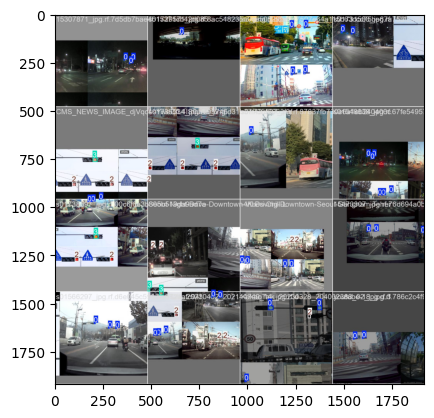

In [ ]:
# Training plots will be unbalanced
plt.imshow(img)

# Train with weighted dataloader

In [10]:
# Monkey patch method to use weighted dataloader
# This might not work with multi-GPU training.
# Go to the end of the notebook for multi-GPU workaround.
build.YOLODataset = YOLOWeightedDataset

In [11]:
model = YOLO("yolov8n.pt")

In [12]:
results = model.train(data="/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/shudian_nc8.yaml", epochs=1)

New https://pypi.org/project/ultralytics/8.3.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.55 🚀 Python-3.10.14 torch-2.4.1+cu121 CUDA:0 (NVIDIA H800 PCIe, 81110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/shudian_nc8.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

train: Scanning /data1/datasets/shudian/aug_cgw/labels... 72640 images, 7487 backgrounds, 2 corrupt: 100%|██████████| 72642/72642 [01:05<00:00, 1102.09it/s]


train: WARNING ⚠️ /data1/datasets/shudian/images/shudian_00078843.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/data1/datasets/shudian/images/shudian_00078843.jpg'
train: WARNING ⚠️ /data1/datasets/shudian/images/shudian_00096429.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/data1/datasets/shudian/images/shudian_00096429.jpg'
train: New cache created: /data1/datasets/shudian/aug_cgw/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /data1/datasets/shudian/labels... 14920 images, 1640 backgrounds, 1 corrupt: 100%|██████████| 14921/14921 [00:17<00:00, 841.50it/s] 

val: WARNING ⚠️ /data1/datasets/shudian/images/shudian_00108539.jpg: ignoring corrupt image/label: [Errno 2] No such file or directory: '/data1/datasets/shudian/images/shudian_00108539.jpg'


val: New cache created: /data1/datasets/shudian/labels.cache
Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.36G       1.96        4.4      1.744         66        640:   6%|▋         | 287/4540 [00:35<08:24,  8.43it/s]Corrupt JPEG data: bad Huffman code
        1/1      2.46G      1.809      3.338      1.623         65        640:  25%|██▌       | 1142/4540 [02:18<06:00,  9.41it/s]Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
        1/1      2.46G      1.799       3.27      1.617         77        640:  27%|██▋       | 1245/4540 [02:31<07:05,  7.74it/s]Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
        1/1      2.46G      1.782      3.111      1.599         52        640:  33%|███▎      | 1518/4540 [03:04<05:41,  8.86it/s]Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
        1/1      2.47G      1.712      2.339       1.54         44        640: 100%|██████████| 4540/4540 [09:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 242/467 [01:15<01:13,  3.05it/s]C

                   all      14920      37615      0.565      0.471      0.487      0.256

1 epochs completed in 0.193 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.14 torch-2.4.1+cu121 CUDA:0 (NVIDIA H800 PCIe, 81110MiB)
Model summary (fused): 168 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 243/467 [01:03<01:01,  3.67it/s]Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 467/467 [02:02<00:00,  3.82it/s]


                   all      14920      37615      0.564      0.471      0.487      0.256
                  fire        288        320      0.495      0.622      0.571      0.302
                 smoke        928        981      0.408      0.288      0.295      0.142
              niaochao       1017       1045      0.782      0.786      0.831      0.439
                  dxyw        607        662      0.716       0.68      0.728       0.46
                  sgjx       9001      19697      0.566      0.373       0.41      0.181
             caigangwa       2290       3828      0.381      0.384      0.318      0.163
          fangchenwang       1697       3089      0.503      0.344      0.366      0.191
                tadiao       3145       7993      0.664      0.291      0.379       0.17
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train3


In [13]:
# Verify the type of dataset used. It should say
# YOLOWeightedDataset
model.trainer.train_loader.dataset

In [14]:
img = cv2.imread("/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/demo.jpg")[...,::-1]

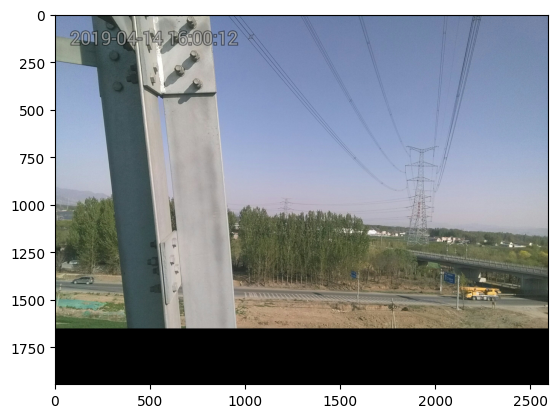

In [23]:
# Training plots will be balanced
plt.imshow(img)

# Check class balance

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def verify_class_balance(dataset, num_samples=1000):
    """
    Verifies whether the __getitem__ method in the YOLOWeightedDataset class returns a balanced class output.

    Args:
        dataset: An instance of YOLOWeightedDataset.
        num_samples: Number of samples to draw from the dataset.

    Returns:
        class_counts: A dictionary containing the class counts.
    """
    all_labels = []
    num_samples = min(len(dataset.labels), num_samples)

    if dataset.train_mode:
        choices = np.random.choice(len(dataset.labels), size=num_samples, p=dataset.probabilities)
    else:
        choices = np.random.choice(len(dataset.labels), size=num_samples, replace=False)

    for i in choices:
        label = dataset.labels[i]["cls"]
        all_labels.extend(label.reshape(-1).astype(int))

    class_counts = Counter(all_labels)
    return class_counts

def plot_class_balance(weighted_cnts, unweighted_cnts, class_names):
    """
    Plots the comparison of class distribution between training and validation modes.

    Args:
        weighted_cnts: A dictionary containing the class counts in weighted mode.
        unweighted_cnts: A dictionary containing the class counts in unweighted mode.
        class_names: A list of class names.
    """
    classes = range(len(class_names))
    weighted_values = [weighted_cnts.get(c, 0) for c in classes]
    unweighted_values = [unweighted_cnts.get(c, 0) for c in classes]

    width = 0.35  # Bar width

    fig, ax = plt.subplots()
    ax.bar(classes, unweighted_values, width, label='Normal mode')
    ax.bar([c + width for c in classes], weighted_values, width, label='Weighted Mode')

    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution in Normal vs Weighted Modes')
    ax.set_xticks([c + width / 2 for c in classes])
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    # plt.savefig("/data1/home/ycx/ycxGit/YOLOTricks/weightedDataloader/dataset/demo_plt.jpg")
    plt.show()

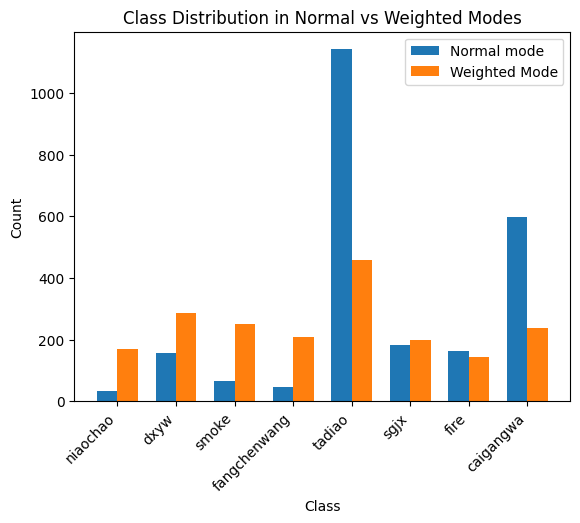

In [25]:
# You can test different aggregation functions np.max, np.sum, np.median, np.mean
# model.trainer.train_loader.dataset.agg_func = np.sum
model.trainer.train_loader.dataset.agg_func = np.mean
model.trainer.train_loader.dataset.weights = model.trainer.train_loader.dataset.calculate_weights()
model.trainer.train_loader.dataset.probabilities = model.trainer.train_loader.dataset.calculate_probabilities()

# Get class counts in weighted mode
model.trainer.train_loader.dataset.train_mode = True
weighted_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Get class counts in default mode
model.trainer.train_loader.dataset.train_mode = False
default_counts = verify_class_balance(model.trainer.train_loader.dataset, num_samples=1000)

# Plot the comparison
plot_class_balance(weighted_counts, default_counts, set(model.trainer.train_loader.dataset.data["names"].values()))

In [19]:
default_counts

Counter({4: 1117, 7: 628, 5: 192, 1: 154, 6: 154, 2: 45, 3: 34, 0: 31})

# Monkey-patching for multi-GPU

In [ ]:

# Use callbacks to monkey-patch

def patch_dataset(trainer):
  from ultralytics.data.dataset import YOLODataset
  import ultralytics.data.build as build
  import numpy as np

  class YOLOWeightedDataset(YOLODataset):
      def __init__(self, *args, mode="train", **kwargs):
          """
          Initialize the WeightedDataset.

          Args:
              class_weights (list or numpy array): A list or array of weights corresponding to each class.
          """

          super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

          self.train_mode = "train" in self.prefix

          # You can also specify weights manually instead
          self.count_instances()
          class_weights = np.sum(self.counts) / self.counts
          self.agg_func = np.mean

          self.class_weights = np.array(class_weights)
          self.weights = self.calculate_weights()
          self.probabilities = self.calculate_probabilities()

      def count_instances(self):
          """
          Count the number of instances per class

          Returns:
              dict: A dict containing the counts for each class.
          """
          self.counts = [0 for i in range(len(self.data["names"]))]
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)
              for id in cls:
                  self.counts[id] += 1

          self.counts = np.array(self.counts)
          self.counts = np.where(self.counts == 0, 1, self.counts)

      def calculate_weights(self):
          """
          Calculate the aggregated weight for each label based on class weights.

          Returns:
              list: A list of aggregated weights corresponding to each label.
          """
          weights = []
          for label in self.labels:
              cls = label['cls'].reshape(-1).astype(int)

              # Give a default weight to background class
              if cls.size == 0:
                weights.append(1)
                continue

              # Take mean of weights
              # You can change this weight aggregation function to aggregate weights differently
              # weight = np.mean(self.class_weights[cls])
              # weight = np.max(self.class_weights[cls])
              weight = self.agg_func(self.class_weights[cls])
              weights.append(weight)
          return weights

      def calculate_probabilities(self):
          """
          Calculate and store the sampling probabilities based on the weights.

          Returns:
              list: A list of sampling probabilities corresponding to each label.
          """
          total_weight = sum(self.weights)
          probabilities = [w / total_weight for w in self.weights]
          return probabilities

      def __getitem__(self, index):
          """
          Return transformed label information based on the sampled index.
          """
          # Don't use for validation
          if not self.train_mode:
              return self.transforms(self.get_image_and_label(index))
          else:
              index = np.random.choice(len(self.labels), p=self.probabilities)
              return self.transforms(self.get_image_and_label(index))

       build.YOLODataset = YOLOWeightedDataset

In [ ]:
model = YOLO("yolov8n.pt")

In [ ]:
model.add_callback("on_pretrain_routine_start", patch_dataset)

In [ ]:
results = model.train(data="/content/Traffic-light-10/data.yaml", epochs=50)